# Laboratory 1: setting up Twitter API

## Set up

In [ ]:
import os

os.environ['TOKEN'] = 'your token here'

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

### Import libraries

In [1]:
import requests
import pandas as pd
import time
import re
import string
import ast

If you need to download a library, use the following code, just specify the name of the library you need (here we downloaded emoji library)

In [ ]:
!pip install emoji

### Set up headers

In [ ]:
def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

In [ ]:
headers = create_headers(os.environ['TOKEN'])

## Download data

Date format and other parameter explanations available here:

https://developer.twitter.com/en/docs/twitter-api/premium/search-api/api-reference/premium-search#DataParameters

In [ ]:
def create_url(keyword, start_date, end_date, env_label, endpoint="fullarchive"):
    search_url = "https://api.twitter.com/1.1/tweets/search/{}.json".format(endpoint + "/" + env_label)

    #change params based on the endpoint you are using
    query_params = {'query': keyword, 'fromDate': start_date, 'toDate': end_date}
    return (search_url, query_params)

In [ ]:
def connect_to_endpoint(url, headers, params, next_token=None):
    if next_token is not None and next_token != '':
        params['next'] = next_token
    response = requests.request("GET", url, headers=headers, params=params)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [ ]:
def get_data(keyword, start_time, end_time, next_token, env_label, endpoint):
    results = []
    dCounter = 0
    while next_token is not None and dCounter < 10:  #change dCounter to 10 to retrieve 1k data
        ##this part here for one request
        url = create_url(keyword, start_time, end_time, env_label, endpoint)
        json_response = connect_to_endpoint(url[0], headers, url[1], next_token)

        if "results" in json_response:
            results.extend(json_response["results"])
        ### up until this point
        if "next" in json_response:
            next_token = json_response["next"]
            dCounter += 1
        else:
            next_token = None
        time.sleep(1)

    return results

In [ ]:
def get_single_response(keyword, start_time, end_time, env_label, endpoint):
    #endpoint can be fullarchive or 30day
    results = []
    url = create_url(keyword, start_time, end_time, env_label, endpoint)
    json_response = connect_to_endpoint(url[0], headers, url[1])

    if "results" in json_response:
        results.extend(json_response["results"])

    return results

In [ ]:
#if you are using the 30day endpoint, make sure you specify dates that are within 30day range!
#To get small data of size "100" use, get_single_response
#change the hashtags to your liking
# with "get_data" we are querying for 1k data - see the definition of get_data func above
tweets = get_data("(gulpanra OR JusticeforGulPanra OR StopGenocideOfTransgenders OR TransLivesMatter) lang:en",
                  "202001010000", "202012310000", "", "NSdev", "fullarchive")
#tweets = get_single_response("(EndTransViolence OR BeelaCrisis OR JusticeForBijlee OR JusticeForToffi OR JusticeforGulPanra OR TransLivesMatter) lang:en", "202001010000", "202112310000","NSdev", "fullarchive")

### Inspect data

In [ ]:
len(tweets)

In [ ]:
tweets[0]

# Laboratory 2: working with Twitter data

First, we want to convert the data into Pandas DataFrame. This format enables us easy manipulation of the data as well as saving/loading data.

Since we have our tweets saved as a list of dictionaries, we can easily convert it to DataFrame by executing the cell blow.

In [ ]:
tweets_df = pd.DataFrame(tweets)

In [ ]:
tweets_df

### Saving the results

Once we have our Tweets as a DataFrame it is a good idea to save it on the disk. 

Be mindful of the fact that the storage of a Colab notebook is deleted everytime runtime is interrupted or restarted, so you need to manually download it to your computer or mount your Google Drive and save it there (this option is unavailable if you're using university's email account for Drive).

In [ ]:
path = "Desktop\network proje"  #enter the path to your Drive or leave this as default

We can save it as a comma-separated values file, which enables opening it in a spreadsheet editor and inspecting it.

In [ ]:
tweets_df.to_csv(path + "trans_case1.csv", index=False)

In order to preserve datatypes, we should save it as a parquet or pickle file.

In [ ]:
tweets_df.to_pickle(path + "trans_case1.pkl")

### Loading the data

If you want to load the results you have previously saved, simply execute the next code, specifying the path to the file.

You will need to either upload it to the Colab workspace or copy the path to the file on Drive.

In [ ]:
tweets_df = pd.read_pickle("trans_case1.pkl")

In [ ]:
tweets_df

### Preprocessing the data

In our dataframe we have the entire Tweet object. Some columns that might be of particular interest to us are: 

*   created_at - date when Tweet was posted
*   id/id_str - unique Tweet identifiers
*   text - the content of the Tweet
*   user - information about the user who posted the Tweet
*   retweeted_status  - information about the original Tweet
*   quote/reply/retweet/favorite count - Tweet metrics
*   entities - hashtags, urls, user_mentions present in Tweet

We can filter the dataframe and keep only columns we are interested in. You can pick which columns you'd like to keep and put them int the column_list below.



In [ ]:
#Everything is filtered below in Umut's code, no need to do it now

#tweets_filtered = tweets_df.copy() #it's a good idea to work on the copy of original dataframe, so we can always go back to it if we mess something up
#column_list = ["created_at", "id_str", "text", "user", "retweeted_status", "quote_count", "reply_count", "retweet_count", "favorite_count", "entities"]
#tweets_filtered = tweets_filtered[column_list]
# tweets_filtered

In [320]:
import enum


class CountMode(enum.Enum):
    count_within_all_tweets = 1
    count_within_verified_tweets = 2
    count_within_regular_tweets = 3

In [321]:
def preProcessData(df):
    for index, row in df.iterrows():
        # get full_text and entities(hashtags mentions etc.) of the tweet
        if row['truncated']:
            tweet = {
                "full_text": ast.literal_eval(row['extended_tweet'])['full_text'],
                "entities": ast.literal_eval(row['extended_tweet'])['entities']
            }
        else:
            # if the tweet is retweeted, this status will not be na
            if ('retweeted_status' in row) and (not pd.isna(row['retweeted_status'])):
                originalTweet = ast.literal_eval(row['retweeted_status'])
                userTagName = originalTweet['user']['screen_name']

                # if the text is truncated
                if originalTweet['truncated']:
                    tweet = {
                        "full_text": "RT @" + userTagName + ": " + originalTweet['extended_tweet']['full_text'],
                        "entities": originalTweet['extended_tweet']['entities']
                    }
                else:
                    tweet = {
                        "full_text": "RT @" + userTagName + ": " + originalTweet['text'],
                        "entities": originalTweet['entities']
                    }

                del originalTweet
                del userTagName

            # if the tweet is original and not truncated
            else:
                tweet = {
                    "full_text": row['text'],
                    "entities": ast.literal_eval(row['entities'])
                }

        # get Username & User Tag & Location & Verification status of account
        tweet["username"] = ast.literal_eval(row['user'])['name']
        tweet["screen_name"] = ast.literal_eval(row['user'])['screen_name']
        tweet["location"] = ast.literal_eval(row['user'])['location']
        tweet["is_verified"] = ast.literal_eval(row['user'])['verified']

        # get Quote & Fav & RT & Reply counts
        tweet["quote_count"] = row['quote_count']
        tweet["favorite_count"] = row['quote_count']
        tweet["retweet_count"] = row['retweet_count']
        tweet["reply_count"] = row['reply_count']

        # get Tweet creation date&time
        tweet["created_at"] = row['created_at']

        # get TweetID
        tweet["tweet_id"] = row['id']

        tweets.append(tweet)

        del tweet
        del row
        del index


def countNumberOfRetweetedTweets(tweets, countMode):
    # Separate RTs and original tweets
    for tweet in tweets:
        if bool(re.match(r'(RT @[\w]+:)', tweet["full_text"])):
            if countMode == CountMode.count_within_all_tweets:
                rts.append(tweet)
            elif countMode == CountMode.count_within_verified_tweets:
                verified_rts.append(tweet)
            elif countMode == CountMode.count_within_regular_tweets:
                regular_rts.append(tweet)
        else:
            if countMode == CountMode.count_within_all_tweets:
                non_rt.append(tweet)
            elif countMode == CountMode.count_within_verified_tweets:
                verified_non_rt.append(tweet)
            elif countMode == CountMode.count_within_regular_tweets:
                regular_non_rt.append(tweet)
        del tweet


# Distinguish tweets according to their account verification status
def countTweetsFromVerifiedAccounts(tweets):
    for tweet in tweets:
        if tweet["is_verified"]:
            tweets_from_verified_accounts.append(tweet)
        else:
            tweets_from_regular_accounts.append(tweet)

        del tweet


# filter locations according to city names given in listOfCities
def filterLocations(tweets, listOfCities):
    filtered_tweets = []

    for tweet in tweets:
        for index, city in listOfCities.iterrows():
            if city['city'] in tweet['location']:
                filtered_tweets.append(tweet)
                break
    return filtered_tweets


In [323]:
import ast
import re
import pandas as pd
df1 = pd.read_csv('/Users/Selen/Desktop/nsproject/network proje/hashtags/Pakistan_male/pakistan_male_case1.csv')
df2 = pd.read_csv('/Users/Selen/Desktop/nsproject/network proje/hashtags/Pakistan_male/pakistan_male_case2.csv')
df3 = pd.read_csv('/Users/Selen/Desktop/nsproject/network proje/hashtags/Pakistan_male/pakistan_male_case3.csv')




#df3 = pd.read_csv('../Pakistan_male/pakistan_male_case3.csv')
tweets = []
tweets_from_verified_accounts = []
tweets_from_regular_accounts = []

rts = []
non_rt = []
verified_rts = []
regular_rts = []
verified_non_rt = []
regular_non_rt = []

#pakistanCities = pd.read_csv('pakistanCities.csv')
#egyptCities = pd.read_csv('egyptCities.csv')
#dfs = [df1, df2 ,df3]

# define and add the concatenated data as vars into below statement.
dfs = pd.concat([df1,df2,df3], ignore_index=True, sort=False)

#index column was not incrementing from 0 through 3000 for 3k data. So we resetted it to have an index column of 0-2999
dfs.reset_index(drop=True, inplace=True)

df_final = dfs.copy()  # to work on a copy, copied the original df
preProcessData(df_final)  # full text, column filtering are applied to the df

# Iterates over the entire dataset
countTweetsFromVerifiedAccounts(tweets)  # count of Tweets From Verified Accounts

# total number of retweeted all tweets
countNumberOfRetweetedTweets(tweets, CountMode.count_within_all_tweets)

# total number of retweeted only verified tweets
countNumberOfRetweetedTweets(tweets_from_verified_accounts, CountMode.count_within_verified_tweets)

# total number of retweeted only regular tweets
countNumberOfRetweetedTweets(tweets_from_regular_accounts, CountMode.count_within_regular_tweets)
# df_final

In [324]:
# DataFrame of whole network and in the last line, it saved it as a csv file
tweets_df = pd.DataFrame(tweets)
tweets_df
tweets_df.to_csv("SON_pakistan_male.csv", index=False)  # change the name according to your case

In [325]:
tweets_filtered=tweets_df

In [326]:
tweets_from_verified_accounts_df = pd.DataFrame(tweets_from_verified_accounts)
tweets_from_verified_accounts_df

,full_text,entities,username,screen_name,location,is_verified,quote_count,favorite_count,retweet_count,reply_count,created_at,tweet_id
0,@salsbeelll Here you go. This is an image that...,"{'hashtags': [{'text': 'JusticeforAliZafar', '...",Mahwash Ajaz 🇵🇰,mahwashajaz_,None,True,0,0,5,1,Sat Dec 12 17:51:42 +0000 2020,1337817416886333441
1,RT @MBilaloo: #JusticeForAliZafar because we h...,"{'hashtags': [{'text': 'JusticeForAliZafar', '...",Mahwash Ajaz 🇵🇰,mahwashajaz_,None,True,0,0,0,0,Sat Dec 12 17:42:46 +0000 2020,1337815167887937539
2,RT @HeavenlyKaif1: Kindest he is! \nSuch a pur...,"{'hashtags': [{'text': 'JusticeforAliZafar', '...",Mahwash Ajaz 🇵🇰,mahwashajaz_,None,True,0,0,0,0,Sat Dec 12 17:41:33 +0000 2020,1337814862945280003
3,RT @amyy_zee: We want justice!!! #JusticeForAl...,"{'hashtags': [{'text': 'JusticeForAliZafar', '...",Mahwash Ajaz 🇵🇰,mahwashajaz_,None,True,0,0,0,0,Sat Dec 12 17:40:09 +0000 2020,1337814509470306308
4,RT @Fahad4014: Extremely disturbed to see #Usm...,"{'hashtags': [{'text': 'UsmanMukhtar', 'indice...",Anees Hanif,anees_avis,"Karachi, Pakistan",True,0,0,0,0,Tue Jul 27 15:33:32 +0000 2021,1420044693199536130
5,Harrasers must be call out irrespect of their ...,{'hashtags': [{'text': 'StayStrongUsmanMukhtar...,Amnah Jabeen,AmnahJPlus,"Islamabad, Pakistan",True,1,1,0,1,Tue Jul 27 15:26:51 +0000 2021,1420043010415464452
6,"‘Gilligan’s Island’ star Dawn Wells, who playe...","{'hashtags': [], 'urls': [{'url': 'https://t.c...",larry mcshane,lmcshanenydn,NYC,True,0,0,0,0,Wed Dec 30 23:59:22 +0000 2020,1344432927141224449
7,Guys? Masks. Social distance. Then — get vacc...,"{'hashtags': [{'text': 'DawnWells', 'indices':...",John McNamara,johnthemcnamara,"Los Angeles, CA",True,0,0,1,0,Wed Dec 30 23:58:47 +0000 2020,1344432779904208896
8,"‘Gilligan’s Island’ star Dawn Wells dies, COVI...","{'hashtags': [], 'urls': [{'url': 'https://t.c...",PeterboroughExaminer,PtboExaminer,"Peterborough, Ontario, Canada",True,0,0,0,0,Wed Dec 30 23:58:44 +0000 2020,1344432764947468293
9,"It’s heartwarming seeing Mary Ann, Dawn Wells,...","{'hashtags': [], 'urls': [], 'user_mentions': ...",Mike Sington,MikeSington,Los Angeles and the World,True,0,0,1,1,Wed Dec 30 23:58:13 +0000 2020,1344432637994176515


In [327]:
# DataFrame of tweets from regular accounts
tweets_from_regular_accounts_df = pd.DataFrame(tweets_from_regular_accounts)
tweets_from_regular_accounts_df

,full_text,entities,username,screen_name,location,is_verified,quote_count,favorite_count,retweet_count,reply_count,created_at,tweet_id
0,You kidding me 🚀🤣🤣🤣 unconstitutional. #Justice...,"{'hashtags': [{'text': 'JusticeForAliZafar', '...",حسام احمد رامے,BrassWires,Somewhere on 🌎🌍🌎,False,0,0,0,0,Thu Dec 23 11:03:31 +0000 2021,1473972532487274498
1,"@Osamarants @desibaddiee Guys, I don’t know if...","{'hashtags': [{'text': 'istandwithAliZafar', '...",AZian Channo💃🏻,iLoveAli_Zafar,in Ali Zafar's heart,False,0,0,0,0,Sat Dec 11 19:11:24 +0000 2021,1469746659026481152
2,RT @iLoveAli_Zafar: @_galactictony @Messifc111...,"{'hashtags': [{'text': 'istandwithAliZafar', '...",Afra Alam,azianAfra_Alam,"Kolkata, India",False,0,0,0,0,Wed Nov 03 05:27:12 +0000 2021,1455768502803918851
3,@_galactictony @Messifc111 @khaismax @shradhar...,"{'hashtags': [{'text': 'istandwithAliZafar', '...",AZian Channo💃🏻,iLoveAli_Zafar,in Ali Zafar's heart,False,0,0,1,0,Tue Nov 02 19:18:49 +0000 2021,1455615396917174272
4,RT @iLoveAli_Zafar: @cysterz @tryinaad false a...,"{'hashtags': [{'text': 'justiceForAliZafar', '...",Afra Alam,azianAfra_Alam,"Kolkata, India",False,0,0,0,0,Tue Nov 02 18:07:37 +0000 2021,1455597479936679941
...,...,...,...,...,...,...,...,...,...,...,...,...
2965,Disclaimer: i'm no expert. I just did some res...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",🐞| T-ARA 👑,jindawnie,None,False,0,0,0,1,Wed Dec 30 23:45:34 +0000 2020,1344429454400090112
2966,"@chipcoffey Always loved that show, RIP Dawn.","{'hashtags': [], 'urls': [], 'user_mentions': ...",Dorinski18 .,dorinski57,"Fort Worth, TX",False,0,0,0,0,Wed Dec 30 23:45:34 +0000 2020,1344429454299426816
2967,DAWN x Punk influence https://t.co/WSepPWqPDa,"{'hashtags': [], 'urls': [], 'user_mentions': ...",🐞| T-ARA 👑,jindawnie,None,False,3,3,3,1,Wed Dec 30 23:45:34 +0000 2020,1344429452156149761
2968,"Dawn Wells, Mary Ann on 'Gilligan's Island,' d...","{'hashtags': [], 'urls': [{'url': 'https://t.c...",IATSE 212 Calgary,Iatselocal212,"Calgary, Alberta",False,0,0,0,0,Wed Dec 30 23:45:34 +0000 2020,1344429450872696836


In [328]:
# retweeted tweets
len(rts)  # length of the rt tweets
rts_df = pd.DataFrame(rts)
rts_df

,full_text,entities,username,screen_name,location,is_verified,quote_count,favorite_count,retweet_count,reply_count,created_at,tweet_id
0,RT @iLoveAli_Zafar: @_galactictony @Messifc111...,"{'hashtags': [{'text': 'istandwithAliZafar', '...",Afra Alam,azianAfra_Alam,"Kolkata, India",False,0,0,0,0,Wed Nov 03 05:27:12 +0000 2021,1455768502803918851
1,RT @iLoveAli_Zafar: @cysterz @tryinaad false a...,"{'hashtags': [{'text': 'justiceForAliZafar', '...",Afra Alam,azianAfra_Alam,"Kolkata, India",False,0,0,0,0,Tue Nov 02 18:07:37 +0000 2021,1455597479936679941
2,RT @iLoveAli_Zafar: @Aligulpir False allegatio...,"{'hashtags': [{'text': 'istandwithAliZafar', '...",M. Bilal 🇵🇰🇵🇸,MBilaloo,"Karachi, Sindh, Pakistan",False,0,0,0,0,Fri Sep 10 01:17:11 +0000 2021,1436136639898832902
3,RT @iLoveAli_Zafar: @Aligulpir False allegatio...,"{'hashtags': [{'text': 'istandwithAliZafar', '...",Ahmed Sheikh,AhmSheikhh,Pakistan,False,0,0,0,0,Thu Sep 09 11:07:28 +0000 2021,1435922802184495106
4,RT @iLoveAli_Zafar: @zo_BasimStydia Because it...,"{'hashtags': [{'text': 'JusticeForAliZafar', '...",Afra Alam,azianAfra_Alam,"Kolkata, India",False,0,0,0,0,Sun Aug 22 14:25:56 +0000 2021,1429449765184413702
...,...,...,...,...,...,...,...,...,...,...,...,...
1939,RT @abc7george: #BREAKING - Actress Dawn Wells...,"{'hashtags': [{'text': 'BREAKING', 'indices': ...",🔮crystals BACK in ma bra 🇯🇲,Jamaican_candy,Baltimore,False,0,0,0,0,Wed Dec 30 23:45:48 +0000 2020,1344429510725423104
1940,RT @alfranken: Sat w/Dawn Wells on a plane. Ve...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",John McLaughlin,je_mclaughlin,"New Brunswick, NJ",False,0,0,0,0,Wed Dec 30 23:45:47 +0000 2020,1344429508368207875
1941,RT @startrektour: Devastated to hear of the pa...,"{'hashtags': [{'text': 'RIPDawnWells', 'indice...",Zacharias C .Moore,beliefinaction,"Philadelphia,Pa",False,0,0,0,0,Wed Dec 30 23:45:41 +0000 2020,1344429482648752129
1942,RT @hapoelorient: As the #NewYearsHonours is a...,"{'hashtags': [{'text': 'NewYearsHonours', 'ind...",Pinesy™® Marxist,taxi_liverpool,Liverpool L13,False,0,0,0,0,Wed Dec 30 23:45:41 +0000 2020,1344429481809874947


In [329]:
# not retweeted tweets, basically the remaining tweets
len(non_rt)  # length of not rt tweets
original_tweets_df = pd.DataFrame(non_rt)
original_tweets_df

,full_text,entities,username,screen_name,location,is_verified,quote_count,favorite_count,retweet_count,reply_count,created_at,tweet_id
0,You kidding me 🚀🤣🤣🤣 unconstitutional. #Justice...,"{'hashtags': [{'text': 'JusticeForAliZafar', '...",حسام احمد رامے,BrassWires,Somewhere on 🌎🌍🌎,False,0,0,0,0,Thu Dec 23 11:03:31 +0000 2021,1473972532487274498
1,"@Osamarants @desibaddiee Guys, I don’t know if...","{'hashtags': [{'text': 'istandwithAliZafar', '...",AZian Channo💃🏻,iLoveAli_Zafar,in Ali Zafar's heart,False,0,0,0,0,Sat Dec 11 19:11:24 +0000 2021,1469746659026481152
2,@_galactictony @Messifc111 @khaismax @shradhar...,"{'hashtags': [{'text': 'istandwithAliZafar', '...",AZian Channo💃🏻,iLoveAli_Zafar,in Ali Zafar's heart,False,0,0,1,0,Tue Nov 02 19:18:49 +0000 2021,1455615396917174272
3,"@cysterz @tryinaad false accusations, there is...","{'hashtags': [{'text': 'justiceForAliZafar', '...",AZian Channo💃🏻,iLoveAli_Zafar,in Ali Zafar's heart,False,0,0,1,0,Tue Nov 02 18:03:06 +0000 2021,1455596343251062784
4,@nehasaigol1 @Dawn_News Defamation cases are r...,"{'hashtags': [{'text': 'istandwithAliZafar', '...",AZian Channo💃🏻,iLoveAli_Zafar,in Ali Zafar's heart,False,0,0,0,0,Thu Sep 23 20:50:32 +0000 2021,1441142964000997382
...,...,...,...,...,...,...,...,...,...,...,...,...
1051,"Dawn Wells, star of ""Gilligan's Island,"" dies ...","{'hashtags': [], 'urls': [{'url': 'https://t.c...",Donna Slash,donna_slash,United States,False,0,0,0,0,Wed Dec 30 23:45:35 +0000 2020,1344429458091085824
1052,Disclaimer: i'm no expert. I just did some res...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",🐞| T-ARA 👑,jindawnie,None,False,0,0,0,1,Wed Dec 30 23:45:34 +0000 2020,1344429454400090112
1053,"@chipcoffey Always loved that show, RIP Dawn.","{'hashtags': [], 'urls': [], 'user_mentions': ...",Dorinski18 .,dorinski57,"Fort Worth, TX",False,0,0,0,0,Wed Dec 30 23:45:34 +0000 2020,1344429454299426816
1054,DAWN x Punk influence https://t.co/WSepPWqPDa,"{'hashtags': [], 'urls': [], 'user_mentions': ...",🐞| T-ARA 👑,jindawnie,None,False,3,3,3,1,Wed Dec 30 23:45:34 +0000 2020,1344429452156149761


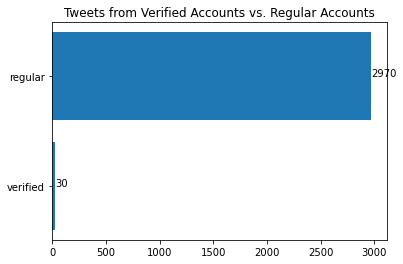

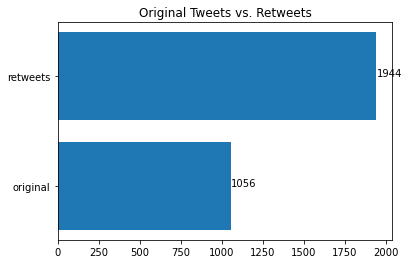

In [330]:
#GRAPH
#THIS GRAPHS WILL BE USED FOR EXPLANATION OF WHY WE CHOOSE TO USE THE COMPLETE DATASET.
#WILL CONTAIN 4 GRAPH:
#1) TWEETS FROM VERIFIED ACCOUNTS VS. REGULAR ACCOUNTS
#2) ORIGINAL TWEETS VS. RETWEETS
#3) ORIGINAL TWEETS VS. RETWEETS FROM VERIFIED ACCOUNTS
#4) ORIGINAL TWEETS VS. RETWEETS FROM REGULAR ACCOUNTS


import matplotlib.pyplot as plt

#GRAPH 1
regular=len(tweets_from_regular_accounts_df)
verified=len(tweets_from_verified_accounts_df)  

x = ['verified','regular']
y= [verified,regular]

plt.barh(x, y)
  
for index, value in enumerate(y):
    plt.text(value, index,
             str(value))
plt.title('Tweets from Verified Accounts vs. Regular Accounts')
plt.savefig('SON_pakistan_male_verified_vs_regular_accounts.png')
plt.show()


#GRAPH 2
original=len(original_tweets_df)
retweeted=len(rts_df)
x = ['original','retweets']
y= [original,retweeted]

plt.barh(x, y)
  
for index, value in enumerate(y):
    plt.text(value, index,
             str(value))
plt.title('Original Tweets vs. Retweets')
plt.savefig('SON_pakistan_male_original_vs_retweet.png')
plt.show()




## Extracting words/hashtags

There are many ways to build networks from the data we download from Twitter.

One possibility is to have a bipartite network of Tweets and words/hashtags and then observe word, hashtag or word-hashtag projections.

### Extracting words

In order to extract words, we first need to clean the Tweet text. This way we will remove punctuation, hashtags/mentions/urls (they are preserved in the entity column anyway). We will also turn all letters to lowercase.

You can also consider removing stopwords, removing words that are not in the english language corpora, lematizing the words, etc. I suggest you research nltk library and its possibilities.

In [331]:
import re
import string

In [332]:
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+", "", tweet)  # remove mentions
    tweet = re.sub("#[A-Za-z0-9]+", "", tweet)  # remove hashtags
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet)  # remove http links
    tweet = " ".join(tweet.split())
    tweet = str.lower(tweet)  #to lowercase
    table = str.maketrans(dict.fromkeys(string.punctuation))
    tweet = tweet.translate(table)  # remove punctuation
    return tweet

In [333]:
tweets_filtered["clean_text"] = tweets_df["full_text"].map(cleaner)

# 3 different usages
#by_changing_to_df = pd.DataFrame(verified_non_rt)
#output1 = by_changing_to_df["full_text"].map(cleaner)

#output2 = cleaner(tweets[0]["full_text"])
#print(tweets[0]["full_text"])
#print(output2)
#output1

We are going to loop through the dataframe and then through the words in the clean text. We are going to add the words as keys to dictionary and use their frequencies as values.

In [334]:
#initialize an empty dict
tweets_filtered["clean_text"] = tweets_df["full_text"].map(cleaner)


unique_words = {}
for row in tweets_filtered.clean_text:
    for word in row.split(" "):
        #if the word is encountered for the first time add to dict as key and set its value to 0
        unique_words.setdefault(word, 0)
        #increase the value (i.e the count) of the word by 1 every time it is encountered
        unique_words[word] += 1

In [335]:
#clean_text is in tweets_filtered
tweets_filtered

,full_text,entities,username,screen_name,location,is_verified,quote_count,favorite_count,retweet_count,reply_count,created_at,tweet_id,clean_text
0,You kidding me 🚀🤣🤣🤣 unconstitutional. #Justice...,"{'hashtags': [{'text': 'JusticeForAliZafar', '...",حسام احمد رامے,BrassWires,Somewhere on 🌎🌍🌎,False,0,0,0,0,Thu Dec 23 11:03:31 +0000 2021,1473972532487274498,you kidding me 🚀🤣🤣🤣 unconstitutional
1,"@Osamarants @desibaddiee Guys, I don’t know if...","{'hashtags': [{'text': 'istandwithAliZafar', '...",AZian Channo💃🏻,iLoveAli_Zafar,in Ali Zafar's heart,False,0,0,0,0,Sat Dec 11 19:11:24 +0000 2021,1469746659026481152,guys i don’t know if she’s wrong but her colle...
2,RT @iLoveAli_Zafar: @_galactictony @Messifc111...,"{'hashtags': [{'text': 'istandwithAliZafar', '...",Afra Alam,azianAfra_Alam,"Kolkata, India",False,0,0,0,0,Wed Nov 03 05:27:12 +0000 2021,1455768502803918851,rt zafar she has been absent since 2018 on pu...
3,@_galactictony @Messifc111 @khaismax @shradhar...,"{'hashtags': [{'text': 'istandwithAliZafar', '...",AZian Channo💃🏻,iLoveAli_Zafar,in Ali Zafar's heart,False,0,0,1,0,Tue Nov 02 19:18:49 +0000 2021,1455615396917174272,she has been absent since 2018 on purpose she...
4,RT @iLoveAli_Zafar: @cysterz @tryinaad false a...,"{'hashtags': [{'text': 'justiceForAliZafar', '...",Afra Alam,azianAfra_Alam,"Kolkata, India",False,0,0,0,0,Tue Nov 02 18:07:37 +0000 2021,1455597479936679941,rt zafar false accusations there is no concret...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,Disclaimer: i'm no expert. I just did some res...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",🐞| T-ARA 👑,jindawnie,None,False,0,0,0,1,Wed Dec 30 23:45:34 +0000 2020,1344429454400090112,disclaimer im no expert i just did some resear...
2996,"@chipcoffey Always loved that show, RIP Dawn.","{'hashtags': [], 'urls': [], 'user_mentions': ...",Dorinski18 .,dorinski57,"Fort Worth, TX",False,0,0,0,0,Wed Dec 30 23:45:34 +0000 2020,1344429454299426816,always loved that show rip dawn
2997,DAWN x Punk influence https://t.co/WSepPWqPDa,"{'hashtags': [], 'urls': [], 'user_mentions': ...",🐞| T-ARA 👑,jindawnie,None,False,3,3,3,1,Wed Dec 30 23:45:34 +0000 2020,1344429452156149761,dawn x punk influence
2998,"Dawn Wells, Mary Ann on 'Gilligan's Island,' d...","{'hashtags': [], 'urls': [{'url': 'https://t.c...",IATSE 212 Calgary,Iatselocal212,"Calgary, Alberta",False,0,0,0,0,Wed Dec 30 23:45:34 +0000 2020,1344429450872696836,dawn wells mary ann on gilligans island dies o...


In [336]:
#remove empty word
unique_words.pop("")
#remove word 'rt'
unique_words.pop("rt")


1944

We can inspect the words as a dataframe. 


You can always save this dataframe as .csv for future reference.

In [337]:
#In the last line, it saves word count df as csv file. It's better to save it so that maybe we'll use it later for the presentation
uw_df = pd.DataFrame.from_dict(unique_words, orient='index').reset_index()
print(uw_df)
uw_df.rename(columns={'index': 'Word', 0: 'Count'}, inplace=True)
uw_df.sort_values(by=['Count'], ascending=False, inplace=True)
uw_df
uw_df.to_csv("SON_pakistan_male_full_network_word_count.csv", index=False)  # change the name to your liking

                 index    0
0                  you  608
1              kidding    1
2                   me  100
3                 🚀🤣🤣🤣    1
4     unconstitutional    1
...                ...  ...
4754            expert    1
4755              punk    3
4756         influence    2
4757      dawndididawn    1
4758               add    1

[4759 rows x 2 columns]


### Extracting the hashtags

We are going to loop through the dataframe and then through the hashtags in the entities. We are going to add the hashtags as keys to dictionary and use their frequencies as values. At the same time, we are going to save them in a list and add them to a separate column to facilitate our future work.

In [ ]:
# no need to run this cell. We already have screen_name column by this point

"""
#TASK-1

sc_name = {}
tweets_filtered["screen_name"] = ""

for idx, row in tweets_filtered.iterrows():
  screen_name_list = []
  for user_mentions in row["entities"]["user_mentions"]:
    sc_name.setdefault(user_mentions['screen_name'], 0)
    sc_name[user_mentions["screen_name"]] += 1
    screen_name_list.append(user_mentions["screen_name"])
  tweets_filtered.at[idx,"screen_names"] = screen_name_list
sc_name

sc_df = pd.DataFrame.from_dict(sc_name, orient='index').reset_index()
sc_df.rename(columns = {'index':'Username', 0:'Count'}, inplace=True)
sc_df.sort_values(by=['Count'], ascending=False, inplace=True)
sc_df
#END OF TASK-1

"""

In [338]:
unique_hashtags = {}

df_to_check = pd.DataFrame(tweets)
# exp_df = verified_non_rt
df_to_check["hashtags"] = ""

for idx, row in df_to_check.iterrows():
    hashtag_list = []
    for hashtag in row["entities"]["hashtags"]:
        unique_hashtags.setdefault("#" + hashtag["text"], 0)
        unique_hashtags['#' + hashtag["text"]] += 1
        hashtag_list.append(hashtag["text"])
    df_to_check.at[idx, "hashtags"] = hashtag_list

unique_hashtags

{'#JusticeForAliZafar': 716,
 '#justiceforalizafar': 99,
 '#istandwithAliZafar': 11,
 '#justiceForAliZafar': 2,
 '#JusticeForJohhnyDepp': 2,
 '#MeToo': 346,
 '#MenToo': 66,
 '#AliZafarisinnocent': 8,
 '#IstandwithAliZafar': 3,
 '#law': 6,
 '#Pakistan': 27,
 '#JusticeForJohnnyDepp': 91,
 '#AliZafar': 193,
 '#JusticeForUsmanMukhtar': 4,
 '#StayStrongUsmanMukhtar': 983,
 '#stopbullying': 2,
 '#JusticeforAliZafar': 169,
 '#StopBullying': 3,
 '#Falseallegation': 2,
 '#FalseAllegations': 17,
 '#AZians': 12,
 '#Haters': 3,
 '#maheenghani': 5,
 '#metoo': 11,
 '#falseallegation': 5,
 '#JusticeForAlizafar': 1,
 '#IStandWithAliZafar': 2,
 '#iStandWithAliZafar': 20,
 '#Coronaviruspakistan': 35,
 '#LeenaGhani': 1,
 '#FaceTheCourtMeeshaShafi': 8,
 '#Alizafar': 12,
 '#Mentoo': 8,
 '#Meera': 2,
 '#MeeshaShafi': 25,
 '#AliZafarprideofpakistan': 2,
 '#SheLIED': 1,
 '#Karma': 1,
 '#Metoo': 18,
 '#Twitter': 3,
 '#AmberHeard': 9,
 '#iffatOmar': 2,
 '#WOMEN': 1,
 '#IffatOmar': 2,
 '#NoorJahan': 1,
 '#Nusrat

In [339]:
uh_df = pd.DataFrame.from_dict(unique_hashtags, orient='index').reset_index()
uh_df.rename(columns={'index': 'Hashtag', 0: 'Count'}, inplace=True)
uh_df.sort_values(by=['Count'], ascending=False, inplace=True)

In [340]:
#In the last line, it saves hashtag count df as csv file. It's better to save it so that maybe we'll use it later for the presentation
uh_df
uh_df.to_csv("SON_pakistan_male_full_network_hashtag_count.csv", index=False)  # change the name to your liking

In [244]:
uh_df

,Hashtag,Count
0,#SarahHegazi,846
6,#sarahhegazi,151
10,#LGBTQ,121
2,#Egypt,119
20,#سارة_حجازي,115
...,...,...
108,#leilaholic,1
104,#lgbtqlivesmatter,1
103,#equality,1
102,#susancollins,1


## Building the network

We are going to use the networkx library, which is a Python library that enables network science analysis of the data.

We are going to use it to create our network and extract edgelist from it, since we can easily import it to Gephi (a software we are going to see in visualization labs).

However, it offers implemented algorithms for analysis (for example PageRank) that you can use out-of-box to analyze your network.

But first, we will loop through our dataframe and connect words and hashtags if they appear together in the same Tweet.

In [341]:
import itertools
import networkx as nx

In [342]:
uh = unique_hashtags.keys()
uw = unique_words.keys()

In [343]:
uw

dict_keys(['you', 'kidding', 'me', '🚀🤣🤣🤣', 'unconstitutional', 'guys', 'i', 'don’t', 'know', 'if', 'she’s', 'wrong', 'but', 'her', 'colleagues', 'are', 'with', 'ali', 'zafar14', 'eyewitnesses', 'azher', 'childhood', 'friend', 'is', 'azall', 'facts', 'amp', 'evidence', 'clearly', 'show', 'zafar', 'innocent', 'tou', 'kya', 'conclusion', 'hay', 'listen', 'to', 'meera', 'ji🙌', '💯', 'she', 'has', 'been', 'absent', 'since', '2018', 'on', 'purpose', 'summoned', 'numerous', 'times', 'for', 'own', 'cross', 'examination', 'read', 'false', 'accusations', 'there', 'no', 'concrete', 'proof', 'at', 'all', 'against', 'infact', 'multiple', 'stated', 'in', 'court', 'nothing', 'happened', 'anything', 'tagged', 'same', 'johnny', 'depp', 'it’s', 'abuse', 'of', 'movement', 'news', 'defamation', 'cases', 'rightfully', 'going', 'az', 'will', 'y’all', 'stop', 'your', 'fake', 'account', 'personality', 'dude', 'a', 'man', 'guts🤣🤣🤣who', 'the', 'trap', 'embarrassment', 'here', 'neha', 'nisar', 'idiot🙃', 'it', 'wh

In [81]:
# No need to run this cell

"""
#SELEN
sc=sc_name.keys()
sc

"""

'\n#SELEN\nsc=sc_name.keys()\nsc\n\n'

In [348]:
df_to_check


,full_text,entities,username,screen_name,location,is_verified,quote_count,favorite_count,retweet_count,reply_count,created_at,tweet_id,hashtags
0,You kidding me 🚀🤣🤣🤣 unconstitutional. #Justice...,"{'hashtags': [{'text': 'JusticeForAliZafar', '...",حسام احمد رامے,BrassWires,Somewhere on 🌎🌍🌎,False,0,0,0,0,Thu Dec 23 11:03:31 +0000 2021,1473972532487274498,"[JusticeForAliZafar, justiceforalizafar]"
1,"@Osamarants @desibaddiee Guys, I don’t know if...","{'hashtags': [{'text': 'istandwithAliZafar', '...",AZian Channo💃🏻,iLoveAli_Zafar,in Ali Zafar's heart,False,0,0,0,0,Sat Dec 11 19:11:24 +0000 2021,1469746659026481152,[istandwithAliZafar]
2,RT @iLoveAli_Zafar: @_galactictony @Messifc111...,"{'hashtags': [{'text': 'istandwithAliZafar', '...",Afra Alam,azianAfra_Alam,"Kolkata, India",False,0,0,0,0,Wed Nov 03 05:27:12 +0000 2021,1455768502803918851,"[istandwithAliZafar, JusticeForAliZafar]"
3,@_galactictony @Messifc111 @khaismax @shradhar...,"{'hashtags': [{'text': 'istandwithAliZafar', '...",AZian Channo💃🏻,iLoveAli_Zafar,in Ali Zafar's heart,False,0,0,1,0,Tue Nov 02 19:18:49 +0000 2021,1455615396917174272,"[istandwithAliZafar, JusticeForAliZafar]"
4,RT @iLoveAli_Zafar: @cysterz @tryinaad false a...,"{'hashtags': [{'text': 'justiceForAliZafar', '...",Afra Alam,azianAfra_Alam,"Kolkata, India",False,0,0,0,0,Tue Nov 02 18:07:37 +0000 2021,1455597479936679941,"[justiceForAliZafar, JusticeForJohhnyDepp, MeToo]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,Disclaimer: i'm no expert. I just did some res...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",🐞| T-ARA 👑,jindawnie,None,False,0,0,0,1,Wed Dec 30 23:45:34 +0000 2020,1344429454400090112,[]
2996,"@chipcoffey Always loved that show, RIP Dawn.","{'hashtags': [], 'urls': [], 'user_mentions': ...",Dorinski18 .,dorinski57,"Fort Worth, TX",False,0,0,0,0,Wed Dec 30 23:45:34 +0000 2020,1344429454299426816,[]
2997,DAWN x Punk influence https://t.co/WSepPWqPDa,"{'hashtags': [], 'urls': [], 'user_mentions': ...",🐞| T-ARA 👑,jindawnie,None,False,3,3,3,1,Wed Dec 30 23:45:34 +0000 2020,1344429452156149761,[]
2998,"Dawn Wells, Mary Ann on 'Gilligan's Island,' d...","{'hashtags': [], 'urls': [{'url': 'https://t.c...",IATSE 212 Calgary,Iatselocal212,"Calgary, Alberta",False,0,0,0,0,Wed Dec 30 23:45:34 +0000 2020,1344429450872696836,[]


In [349]:
#adding hashtags column from df_to_check to tweets_filtered
hashtags=df_to_check["hashtags"]
hashtags
tweets_filtered["hashtags"]=hashtags

In [350]:
tweets_filtered

,full_text,entities,username,screen_name,location,is_verified,quote_count,favorite_count,retweet_count,reply_count,created_at,tweet_id,clean_text,hashtags
0,You kidding me 🚀🤣🤣🤣 unconstitutional. #Justice...,"{'hashtags': [{'text': 'JusticeForAliZafar', '...",حسام احمد رامے,BrassWires,Somewhere on 🌎🌍🌎,False,0,0,0,0,Thu Dec 23 11:03:31 +0000 2021,1473972532487274498,you kidding me 🚀🤣🤣🤣 unconstitutional,"[JusticeForAliZafar, justiceforalizafar]"
1,"@Osamarants @desibaddiee Guys, I don’t know if...","{'hashtags': [{'text': 'istandwithAliZafar', '...",AZian Channo💃🏻,iLoveAli_Zafar,in Ali Zafar's heart,False,0,0,0,0,Sat Dec 11 19:11:24 +0000 2021,1469746659026481152,guys i don’t know if she’s wrong but her colle...,[istandwithAliZafar]
2,RT @iLoveAli_Zafar: @_galactictony @Messifc111...,"{'hashtags': [{'text': 'istandwithAliZafar', '...",Afra Alam,azianAfra_Alam,"Kolkata, India",False,0,0,0,0,Wed Nov 03 05:27:12 +0000 2021,1455768502803918851,rt zafar she has been absent since 2018 on pu...,"[istandwithAliZafar, JusticeForAliZafar]"
3,@_galactictony @Messifc111 @khaismax @shradhar...,"{'hashtags': [{'text': 'istandwithAliZafar', '...",AZian Channo💃🏻,iLoveAli_Zafar,in Ali Zafar's heart,False,0,0,1,0,Tue Nov 02 19:18:49 +0000 2021,1455615396917174272,she has been absent since 2018 on purpose she...,"[istandwithAliZafar, JusticeForAliZafar]"
4,RT @iLoveAli_Zafar: @cysterz @tryinaad false a...,"{'hashtags': [{'text': 'justiceForAliZafar', '...",Afra Alam,azianAfra_Alam,"Kolkata, India",False,0,0,0,0,Tue Nov 02 18:07:37 +0000 2021,1455597479936679941,rt zafar false accusations there is no concret...,"[justiceForAliZafar, JusticeForJohhnyDepp, MeToo]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,Disclaimer: i'm no expert. I just did some res...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",🐞| T-ARA 👑,jindawnie,None,False,0,0,0,1,Wed Dec 30 23:45:34 +0000 2020,1344429454400090112,disclaimer im no expert i just did some resear...,[]
2996,"@chipcoffey Always loved that show, RIP Dawn.","{'hashtags': [], 'urls': [], 'user_mentions': ...",Dorinski18 .,dorinski57,"Fort Worth, TX",False,0,0,0,0,Wed Dec 30 23:45:34 +0000 2020,1344429454299426816,always loved that show rip dawn,[]
2997,DAWN x Punk influence https://t.co/WSepPWqPDa,"{'hashtags': [], 'urls': [], 'user_mentions': ...",🐞| T-ARA 👑,jindawnie,None,False,3,3,3,1,Wed Dec 30 23:45:34 +0000 2020,1344429452156149761,dawn x punk influence,[]
2998,"Dawn Wells, Mary Ann on 'Gilligan's Island,' d...","{'hashtags': [], 'urls': [{'url': 'https://t.c...",IATSE 212 Calgary,Iatselocal212,"Calgary, Alberta",False,0,0,0,0,Wed Dec 30 23:45:34 +0000 2020,1344429450872696836,dawn wells mary ann on gilligans island dies o...,[]


In [351]:
#It creates pairs from all words.
# From this cell on, we will create 3 different networks:
# Network1 = words+hashtags
#Network2 = words only
#Network3 = hashtags only
#This cell is for Network1
network = {}
network_key = 0
for index, row in tweets_filtered.iterrows():
    #hashtags extracted from Tweet do not have the # sign in front of them but we will add it to differentiate hashtags from words
    combined_list = ['#' + hashtag for hashtag in row["hashtags"] if '#' + hashtag in unique_hashtags] + [word for word in str.split(row["clean_text"], " ") if word in uw]
    #itertool product creates Cartesian product of each element in the combined list
    for pair in itertools.product(combined_list, combined_list):
        #exclude self-loops and count each pair only once because our graph is undirected and we do not take self-loops into account
        if pair[0] != pair[1] and not (pair[::-1] in network):
            network.setdefault(pair, 0)
            network[pair] += 1
network_df = pd.DataFrame.from_dict(network, orient="index")
network_df

,0
"(#JusticeForAliZafar, #justiceforalizafar)",1
"(#JusticeForAliZafar, you)",273
"(#JusticeForAliZafar, kidding)",1
"(#JusticeForAliZafar, me)",14
"(#JusticeForAliZafar, 🚀🤣🤣🤣)",1
...,...
"(to, add)",1
"(add, or)",1
"(add, correct)",1
"(x, punk)",1


In [352]:
#This cell is for Network2
# NETWORK OF ONLY WORDS
networkWords = {}
networkWords_key = 0
for index, row in tweets_filtered.iterrows():
    word_list = [word for word in str.split(row["clean_text"], " ") if word in uw]
    #itertool product creates Cartesian product of each element in the word list
    for pair in itertools.product(word_list, word_list):
        #exclude self-loops and count each pair only once because our graph is undirected and we do not take self-loops into account
        if pair[0] != pair[1] and not (pair[::-1] in networkWords):
            networkWords.setdefault(pair, 0)
            networkWords[pair] += 1
networkWords_df = pd.DataFrame.from_dict(networkWords, orient="index")
networkWords_df

,0
"(you, kidding)",1
"(you, me)",19
"(you, 🚀🤣🤣🤣)",1
"(you, unconstitutional)",1
"(kidding, me)",1
...,...
"(to, add)",1
"(add, or)",1
"(add, correct)",1
"(x, punk)",1


In [353]:
#This cell is for Network3
# NETWORK OF ONLY HASHTAGS
networkHashtags = {}
networkHashtags_key = 0
for index, row in tweets_filtered.iterrows():
    #hashtags extracted from Tweet do not have the # sign in front of them but we will add it to differentiate hashtags from words
    hashtag_list = ['#' + hashtag for hashtag in row["hashtags"] if '#' + hashtag in unique_hashtags]
    #itertool product creates Cartesian product of each element in the word list
    for pair in itertools.product(hashtag_list, hashtag_list):
        #exclude self-loops and count each pair only once because our graph is undirected and we do not take self-loops into account
        if pair[0] != pair[1] and not (pair[::-1] in networkHashtags):
            networkHashtags.setdefault(pair, 0)
            networkHashtags[pair] += 1
networkHashtags_df = pd.DataFrame.from_dict(networkHashtags, orient="index")
networkHashtags_df

,0
"(#JusticeForAliZafar, #justiceforalizafar)",1
"(#istandwithAliZafar, #JusticeForAliZafar)",2
"(#justiceForAliZafar, #JusticeForJohhnyDepp)",2
"(#justiceForAliZafar, #MeToo)",2
"(#JusticeForJohhnyDepp, #MeToo)",2
...,...
"(#sussex, #bexhill)",1
"(#sussex, #bexhillonsea)",1
"(#eastsussex, #bexhill)",1
"(#eastsussex, #bexhillonsea)",1


In [354]:
#This cell is for Network1
network_df.reset_index(inplace=True)
network_df.columns = ["pair", "weight"]
network_df.sort_values(by="weight", inplace=True, ascending=False)
network_df

,pair,weight
3072,"(the, of)",1791
2233,"(to, and)",1484
5728,"(for, and)",1407
5777,"(a, of)",1398
4050,"(to, for)",1389
...,...,...
116621,"(zo, via)",1
116620,"(zo, s)",1
116619,"(zo, video)",1
116618,"(zo, official)",1


In [355]:
#This cell is for Network2
# FOR WORD NETWORK
networkWords_df.reset_index(inplace=True)
networkWords_df.columns = ["pair", "weight"]
networkWords_df.sort_values(by="weight", inplace=True, ascending=False)
networkWords_df

,pair,weight
2738,"(the, of)",1791
1994,"(to, and)",1484
5121,"(for, and)",1407
5170,"(a, of)",1398
3615,"(to, for)",1389
...,...,...
105984,"(fellow, calling)",1
105983,"(fellow, rishta)",1
105982,"(fellow, rejects)",1
105981,"(class, can)",1


In [356]:
#This cell is for Network3
# FOR HASHTAG NETWORK
networkHashtags_df.reset_index(inplace=True)
networkHashtags_df.columns = ["pair", "weight"]
networkHashtags_df.sort_values(by="weight", inplace=True, ascending=False)
networkHashtags_df

,pair,weight
316,"(#UsmanMukhtar, #StayStrongUsmanMukhtar)",288
317,"(#MeToo, #StayStrongUsmanMukhtar)",243
315,"(#UsmanMukhtar, #MeToo)",219
12,"(#AliZafar, #JusticeForAliZafar)",182
305,"(#StayStrongUsmanMukhtar, #NotAllMen)",139
...,...,...
717,"(#SardarTanveerExposed, #IsraeliTerrorism)",1
718,"(#StayStrongUsmanMukhtar, #IsraeliTerrorism)",1
738,"(#YesAllMen, #notallwomen)",1
750,"(#MardMarch, #EndMenicide)",1


In [357]:
#This cell is for Network1
#to get weighted graph we need a list of 3-element tuplels (u,v,w) where u and v are nodes and w is a number representing weight
up_weighted = []
for edge in network:
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted.append((edge[0], edge[1], network[edge]))

G = nx.Graph()
G.add_weighted_edges_from(up_weighted)


In [358]:
#This cell is for Network2 & Network3
# list of 3-element tuples for word and hastag networks
up_weighted_words = []
for edge in networkWords:
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted_words.append((edge[0], edge[1], networkWords[edge]))

G_words = nx.Graph()
G_words.add_weighted_edges_from(up_weighted_words)  # words graph

#to get weighted graph we need a list of 3-element tuplels (u,v,w) where u and v are nodes and w is a number representing weight
up_weighted_hashtags = []
for edge in networkHashtags:
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted_hashtags.append((edge[0], edge[1], networkHashtags[edge]))

G_hashtags = nx.Graph()
G_hashtags.add_weighted_edges_from(up_weighted_hashtags)  # hashtags graph

In [201]:
# No need to run this cell, we'll use Gephi for visualization anyways
"""
import matplotlib.pyplot as plt
nx.draw(G, with_labels=True, node_size=1.5, alpha=0.3, arrows=True)
plt.show()
nx.draw(G, with_labels=True)
plt.show()

### ploting words network
nx.draw(G_words, with_labels=True, node_size=1.5, alpha=0.3, arrows=True)
plt.show()
nx.draw(G_words, with_labels=True)
plt.show()

### ploting hashtags network
nx.draw(G_hashtags, with_labels=True, node_size=1.5, alpha=0.3, arrows=True)
plt.show()
nx.draw(G_hashtags, with_labels=True)
plt.show()

"""


'\nimport matplotlib.pyplot as plt\nnx.draw(G, with_labels=True, node_size=1.5, alpha=0.3, arrows=True)\nplt.show()\nnx.draw(G, with_labels=True)\nplt.show()\n\n### ploting words network\nnx.draw(G_words, with_labels=True, node_size=1.5, alpha=0.3, arrows=True)\nplt.show()\nnx.draw(G_words, with_labels=True)\nplt.show()\n\n### ploting hashtags network\nnx.draw(G_hashtags, with_labels=True, node_size=1.5, alpha=0.3, arrows=True)\nplt.show()\nnx.draw(G_hashtags, with_labels=True)\nplt.show()\n\n'

In [359]:
# This cell is for Network1
# WORDS&HASHTAGS NETWORK NODES&EDGES
print(len(G.nodes()))  # nodes=each word in the texts
print(len(G.edges()))  # edges=pairs for each word
#G.edges
#G.nodes

5118
213007


In [360]:
# This cell is for Network2 & Network3

#WORDS NETWORK NODES&EDGES
print(len(G_words.nodes()))
print(len(G_words.edges()))
#HASHTAGS NETWORK NODES&EDGES
print(len(G_hashtags.nodes()))
print(len(G_hashtags.edges()))

4758
193647
326
1238


In [361]:
#In this cell, we rank the nodes using Pagerank function and print the top20 nodes with the highest pageranks

from collections import Counter

pr = nx.pagerank(G, alpha=0.9)  # we ranked the nodes of Network1 with pagerank

# Let's print the top-20 pairs
c = Counter(pr)
top_20_network = c.most_common(20)
print(top_20_network)
print("********************")

pr_word = nx.pagerank(G_words, alpha=0.9)  # we ranked the nodes of Network2 with pagerank

# Let's print the top-20 pairs
c = Counter(pr_word)
top_20_word = c.most_common(20)
print(top_20_word)
print("********************")

pr_hashtag = nx.pagerank(G_hashtags, alpha=0.9)  # we ranked the nodes of Network3 with pagerank

# Let's print the top-20 pairs
c = Counter(pr_hashtag)
top_20_hashtag = c.most_common(20)
print(top_20_hashtag)

[('the', 0.02182443004983051), ('to', 0.02023005689724401), ('a', 0.016777267271800737), ('and', 0.01671049979097452), ('of', 0.01644813592302349), ('for', 0.012726641687678423), ('is', 0.01154062840955162), ('this', 0.010234886206103803), ('in', 0.009992206489989369), ('#StayStrongUsmanMukhtar', 0.009034652685319867), ('on', 0.008719615869256857), ('dawn', 0.00804280035178919), ('was', 0.00794300794848494), ('usman', 0.007899992416664375), ('#JusticeForAliZafar', 0.007042493974333012), ('you', 0.006927099493079107), ('her', 0.006814908387979888), ('i', 0.0068128586503772934), ('she', 0.006425591845002819), ('with', 0.006236336529634833)]
********************
[('the', 0.023308554254275443), ('to', 0.021465092728730286), ('a', 0.017798657785297736), ('and', 0.017452455494593747), ('of', 0.017311528042524237), ('for', 0.013346466452022601), ('is', 0.012207053846159619), ('in', 0.010742511449403387), ('this', 0.010710179215710361), ('on', 0.009236559218241812), ('dawn', 0.0085137129988007

#### SAVE EDGELIST

In [362]:
# Now we're going to save edgelists and nodelists to use for Gephi later
# Change the names according to your case
filename1 = "./SON_pakistan_male_network_edgelist_trans.csv"
filename2 = "./SON_pakistan_male_word_edgelist_trans.csv"
filename3 = "./SON_pakistan_male_hashtag_edgelist_trans.csv"

In [363]:
nx.write_weighted_edgelist(G, filename1, delimiter=",")  # Graph name must be changed!!
nx.write_weighted_edgelist(G_words, filename2, delimiter=",")  # Graph name must be changed!!
nx.write_weighted_edgelist(G_hashtags, filename3, delimiter=",")  # Graph name must be changed!!

In [265]:
# If this cell doesn't work in your device, no worries you can skip it
#add header with appropriate column names (works on collab and Linux/Mac(?))
sed -i.bak 1i"Source,Target,Weight"./ SON_egypt_trans_network_edgelist_trans.csv  # Graph name must be changed!!
sed -i.bak 1i"Source,Target,Weight"./ SON_egypt_trans_word_edgelist_trans.csv  # Graph name must be changed!!
sed -i.bak 1i"Source,Target,Weight"./ SON_egypt_trans_hashtag_edgelist_trans.csv  # Graph name must be changed!!

SyntaxError: invalid syntax (<ipython-input-265-1ba02bd30ed2>, line 3)

### Create Node List


In [364]:
# This creates a csv file of nodes for Network2
word_nodes = pd.DataFrame.from_dict(unique_words, orient="index")
word_nodes.reset_index(inplace=True)
word_nodes["Label"] = word_nodes["index"]
word_nodes.rename(columns={"index": "Id", 0: "delete"}, inplace=True)
word_nodes = word_nodes.drop(columns=['delete'])

word_nodes
word_nodes.to_csv("SON_pakistan_male_word_nodelist.csv", index=False)

In [365]:
# This creates a csv file of nodes for Network3
hashtag_nodes = uh_df.copy()
hashtag_nodes["Label"] = hashtag_nodes["Hashtag"]
hashtag_nodes.rename(columns={"Hashtag": "Id"}, inplace=True)
hashtag_nodes = hashtag_nodes.drop(columns=['Count'])
hashtag_nodes
hashtag_nodes.to_csv("SON_pakistan_male_hashtag_nodelist.csv", index=False)

#### SAVE NODELIST

In [366]:
# This joins the two nodelists above and creates a csv file of nodes for Network1
nodelist = hashtag_nodes.append(word_nodes, ignore_index=True)
nodelist
nodelist.to_csv("SON_pakistan_male_network_nodelist.csv", index=False)

Tasks: 

*   Extract username of user who posted the tweet into a column "screen_name". Follow the procedure we used to get the hashtags.
*   Create a network of users using the mention relation. Is this a directed or undirected graph?
*   We created a network where nodes are mixed (both words and hashtags). Create network of words only and one of hashtags only.
* Pick one of these network and rank the nodes using PageRank centrality. Extract information about top-20 rated nodes.



